# [Introduction to NLP](https://www.datacamp.com/completed/statement-of-accomplishment/course/89ebcecf21a1aa446c1899e9003f59e839a3478c)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adamelliotfields/datacamp/blob/main/notebooks/nlp/introduction_to_nlp/notebook.ipynb)

**Contents**
- [Word Tokenization](#Word-Tokenization)
- [Topic Identification](#Topic-Identification)
- [Named Entity Recognition](#Named-Entity-Recognition)
- [Supervised Learning Classification](#Supervised-Learning-Classification)

In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
!python -m polyglot download embeddings2.fr ner2.fr

In [1]:
import itertools
import nltk
import os
import pickle
import re
import requests
import spacy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter, defaultdict
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize, sent_tokenize, word_tokenize
from polyglot.text import Text
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from urllib.request import urlretrieve
from warnings import filterwarnings
from yellowbrick.classifier import ConfusionMatrix

BASE_URL = "https://raw.githubusercontent.com/adamelliotfields/datacamp/main/notebooks/nlp/introduction_to_nlp/"

filterwarnings("ignore", category=UserWarning, module="spacy")

nltk.download("averaged_perceptron_tagger", quiet=True)
nltk.download("maxent_ne_chunker", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("words", quiet=True)

english_stops = stopwords.words("english")
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "matcher"])

urlretrieve(BASE_URL + "articles.pkl", "articles.pkl")
with open("articles.pkl", "rb") as f:
    articles = pickle.load(f)

urlretrieve(BASE_URL + "debugging.txt", "debugging.txt")
with open("debugging.txt", "r") as f:
    debugging = f.read()

urlretrieve(BASE_URL + "doc.pkl", "doc.pkl")
with open("doc.pkl", "rb") as f:
    doc = pickle.load(f)

urlretrieve(BASE_URL + "french.txt", "french.txt")
with open("french.txt", "r") as f:
    french = f.read()

urlretrieve(BASE_URL + "holy_grail.txt", "holy_grail.txt")
with open("holy_grail.txt", "r") as f:
    holy_grail = f.read()

urlretrieve(BASE_URL + "uber.txt", "uber.txt")
with open("uber.txt", "r") as f:
    uber = f.read()

if not os.path.exists("fake_or_real_news.csv"):
    base = "https://s3.amazonaws.com/assets.datacamp.com/production/course_3629/"
    response = requests.get(base + "fake_or_real_news.csv")
    with open("fake_or_real_news.csv", "w") as f:
        f.write(response.content)

fake_or_real_news = pd.read_csv("fake_or_real_news.csv")

## Word Tokenization

In [2]:
# first 40 lines of holy_grail
scene_one = "\n".join(holy_grail.split("\n")[:40])

# split into sentences
sentences = sent_tokenize(scene_one)

# tokenize 4th sentence
tokenized_sent = word_tokenize(sentences[3])

# set of unique tokens in the entire scene
unique_tokens = set(word_tokenize(scene_one))

# print first 10 words from unique_tokens
print(list(unique_tokens)[:10])

['bird', 'interested', 'master', 'or', 'SOLDIER', 'temperate', 'suggesting', 'African', 'sovereign', 'Britons']


In [3]:
german_text = "Wann gehen wir Pizza essen? 🍕 Und fährst du mit Über? 🚕"

# tokenize words
all_words = word_tokenize(german_text)
print(all_words)

# only capital words
capital_words = r"[A-ZÜ]\w+"
print(regexp_tokenize(german_text, capital_words))

# emoji
emoji = "['\U0001f300-\U0001f5ff'|'\U0001f600-\U0001f64f'|'\U0001f680-\U0001f6ff'|'\u2600-\u26ff\u2700-\u27bf']"
print(regexp_tokenize(german_text, emoji))

['Wann', 'gehen', 'wir', 'Pizza', 'essen', '?', '🍕', 'Und', 'fährst', 'du', 'mit', 'Über', '?', '🚕']
['Wann', 'Pizza', 'Und', 'Über']
['🍕', '🚕']


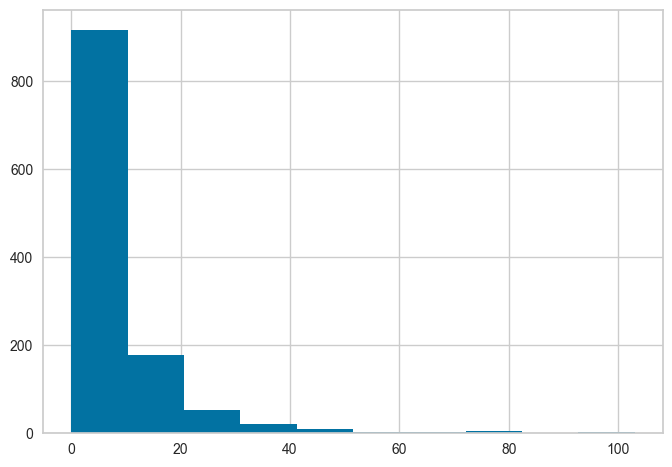

In [4]:
lines = holy_grail.split("\n")
pattern = "[A-Z]{2,}(\s)?(#\d)?([A-Z]{2,})?:"

# replace all script lines
lines = [re.sub(pattern, "", line) for line in lines]

# tokenize lines
tokenized_lines = [regexp_tokenize(line, "\w+") for line in lines]

# frequency list
line_num_words = [len(line) for line in tokenized_lines]

# plot histogram
plt.hist(line_num_words)
plt.show()

## Topic Identification

In [5]:
tokens = word_tokenize(debugging)
lower_tokens = [t.lower() for t in tokens]

# bag-of-words counter
bow_simple = Counter(lower_tokens)
print(bow_simple.most_common(10))

[(',', 151), ('the', 150), ('.', 89), ('of', 81), ("''", 69), ('to', 63), ('a', 60), ('``', 47), ('in', 44), ('and', 41)]


### Lemmatization

_Lemmatization_ is the process of reducing words to their base or root form, known as a _lemma_. It is similar to stemming, but it involves understanding the context. For example, the lemma of "better" is "good", not "bet".

In `nltk`, the `WordNetLemmatizer` uses the [WordNet](https://wordnet.princeton.edu) database to lookup the lemma of a word.

In [6]:
# remove punctuation
alpha_only = [t for t in lower_tokens if t.isalpha()]

# remove stop words
no_stops = [t for t in alpha_only if t not in english_stops]

# instantiate lemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# lemmatize tokens into a new list
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]

# bag-of-words
bow = Counter(lemmatized)
print(bow.most_common(10))

[('debugging', 39), ('system', 25), ('bug', 17), ('software', 16), ('problem', 15), ('tool', 15), ('computer', 14), ('process', 13), ('term', 13), ('debugger', 13)]


### Term Frequency-Inverse Document Frequency

_Term frequency_ measures how frequently a term occurs in a document. It is the total number of occurrences divided by the total number of words in the document. _Inverse document frequency_ measures how important a term is across a set of documents. It is calculated by dividing the total number of documents by the number of documents containing the term, and then taking the logarithm of that quotient.

The idea is that a term is more important if it occurs frequently in a document, but less important if it occurs frequently across a set of documents. For example, the word "sky" could be important in a single document if used frequently, but in a corpus about astronomy it would be less important because it would most likely occur in every document. The significance of a term diminishes as it becomes more commonplace across documents.

The formula for TF-IDF is:

$w_{i,j} = tf_{i,j} \times log(\frac{N}{df_i})$

where $w_{i,j}$ is the TF-IDF weight for term $i$ in document $j$, $tf_{i,j}$ is the number of occurences of term $i$ in document $j$, $N$ is the total number of documents, and $df_i$ is the number of documents containing term $i$.

In [7]:
dictionary = Dictionary(articles)
corpus = [dictionary.doc2bow(a) for a in articles]

# defaultdict allows us to assign a default value for non-existent keys
total_word_count = defaultdict(int)
for id, count in itertools.chain.from_iterable(corpus):
    total_word_count[id] += count

sorted_word_count = sorted(
    total_word_count.items(),
    key=lambda x: x[1],
    reverse=True,
)

# print top 5 words across all documents
for id, count in sorted_word_count[:5]:
    print(dictionary.get(id), count)

'' 1006
computer 598
`` 555
software 450
cite 322


In [8]:
tfidf = TfidfModel(corpus)
tfidf_weights = tfidf[doc]
sorted_tfidf_weights = sorted(
    tfidf_weights,
    key=lambda x: x[1],
    reverse=True,
)

# print top 5 weighted words
for id, weight in sorted_tfidf_weights[:5]:
    print(dictionary.get(id), weight)

reverse 0.4987515710425556
infringement 0.1854420793422032
engineering 0.16280628072296138
interoperability 0.12362805289480211
reverse-engineered 0.12362805289480211


## Named Entity Recognition

_Named Entity Recognition_ (NER) is the NLP task of identifying and classifying _named entities_ in text. Named entities are real-world objects with names, like people, places, dates, famous objects, and so on.

In [9]:
# tokenize sentences
sentences = sent_tokenize(uber)
token_sentences = [word_tokenize(s) for s in sentences]

# tag each tokenized sentence into parts-of-speech
pos_sentences = [nltk.pos_tag(s) for s in token_sentences]

# create named entity chunks
chunked_sentences = nltk.ne_chunk_sents(pos_sentences, binary=True)

# test for stems of the tree with "NE" tags
for sentence in chunked_sentences:
    for chunk in sentence:
        if hasattr(chunk, "label") and chunk.label() == "NE":
            print(chunk)

(NE Uber/NNP)
(NE Beyond/NN)
(NE Apple/NNP)
(NE Uber/NNP)
(NE Uber/NNP)
(NE Travis/NNP Kalanick/NNP)
(NE Tim/NNP Cook/NNP)
(NE Apple/NNP)
(NE Silicon/NNP Valley/NNP)
(NE CEO/NNP)
(NE Yahoo/NNP)
(NE Marissa/NNP Mayer/NNP)


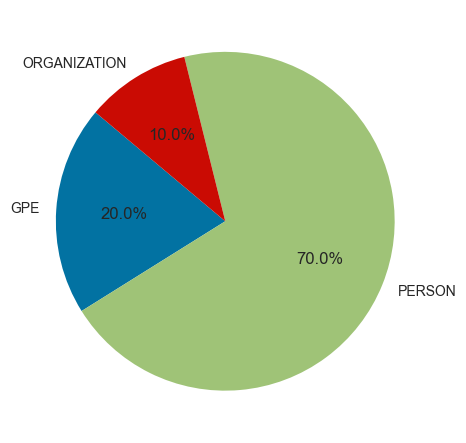

In [10]:
chunked_sentences = nltk.ne_chunk_sents(pos_sentences, binary=False)

# populate categories
ner_categories = defaultdict(int)
for sentence in chunked_sentences:
    for chunk in sentence:
        if hasattr(chunk, "label"):
            ner_categories[chunk.label()] += 1

# plot
labels = list(ner_categories.keys())
values = [ner_categories.get(l) for l in labels]
plt.pie(values, labels=labels, autopct="%1.1f%%", startangle=140)
plt.show()

In [11]:
# create a spaCy document
doc = nlp(uber)

# print named entities
for ent in doc.ents:
    print(ent.label_, ent.text)

ORG Apple
PERSON Uber
PERSON Travis Kalanick
ORG Uber
PERSON Tim Cook
ORG Apple
CARDINAL Millions
ORG Uber
LOC Silicon Valley’s
NORP democratic
ORG Yahoo
PERSON Marissa Mayer
MONEY 186


### Multilingual NER

In [12]:
txt = Text(french)
entities = [(ent.tag, " ".join(ent)) for ent in txt.entities]
entities

[('I-PER', 'Charles Cuvelliez'),
 ('I-PER', 'Charles Cuvelliez'),
 ('I-ORG', 'Bruxelles'),
 ('I-PER', 'l’IA'),
 ('I-PER', 'Julien Maldonato'),
 ('I-ORG', 'Deloitte'),
 ('I-PER', 'Ethiquement'),
 ('I-LOC', 'l’IA'),
 ('I-PER', '.')]

## Supervised Learning Classification

In [13]:
y = fake_or_real_news.label
X_train, X_test, y_train, y_test = train_test_split(
    fake_or_real_news["text"],
    fake_or_real_news["label"],
    test_size=0.33,
    random_state=53,
)

count_vectorizer = CountVectorizer(stop_words="english")
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# first 10 features
print(count_vectorizer.get_feature_names_out()[:10])

['00' '000' '0000' '00000031' '000035' '00006' '0001' '0001pt' '000ft'
 '000km']


In [14]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# first 5 vectors
print(tfidf_train.A[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Naive Bayes

The _Naive Bayes_ algorithm is a supervised learning algorithm based on Bayes' theorem. It is _naive_ because it assumes that each feature independently contributes to the probability of a class (which is not always true). For example, if you were classifying movie genres based on their plot summaries, a Bayesian classifier would consider each word in the summary independently.

In [15]:
# fit with CountVectorizer
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train, y_train)
pred = nb_classifier.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print(score)

0.893352462936394


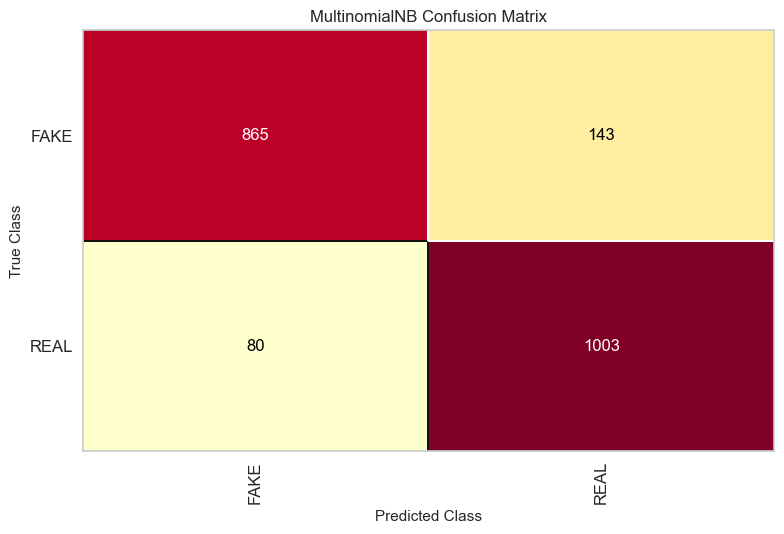

In [16]:
# yellowbrick confusion matrix
cm = ConfusionMatrix(nb_classifier, classes=["FAKE", "REAL"])
cm.fit(count_train, y_train)
cm.score(count_test, y_test)
cm.show()
plt.show()

In [17]:
# fit with TfidfVectorizer
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train, y_train)
pred = nb_classifier.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print(score)

0.8565279770444764


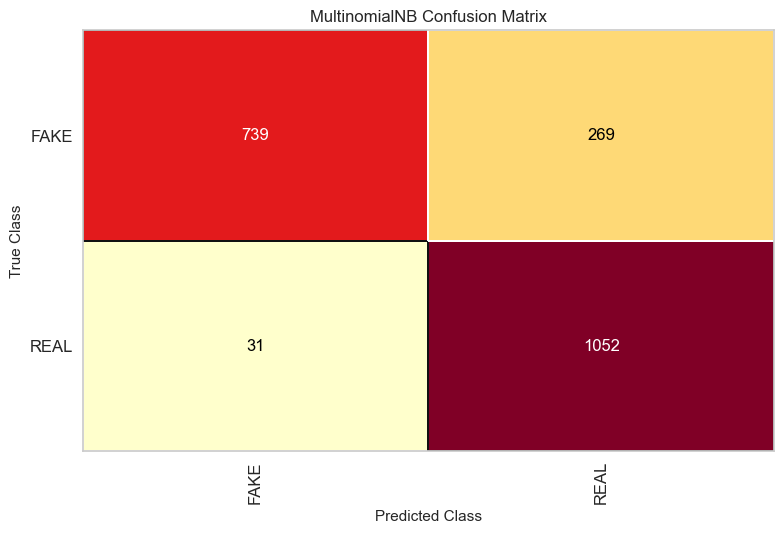

In [18]:
# yellowbrick confusion matrix
cm = ConfusionMatrix(nb_classifier, classes=["FAKE", "REAL"])
cm.fit(tfidf_train, y_train)
cm.score(tfidf_test, y_test)
cm.show()
plt.show()

### Alpha

The _alpha_ hyperparameter is used to prevent zero probabilities in the Naive Bayes algorithm by adding a small constant to each probability. This is known as _Laplace smoothing_.

In [19]:
alphas = np.arange(0.1, 0.5, 0.05)
parameters = {"alpha": alphas}
nb_classifier = MultinomialNB(force_alpha=True)
validator = GridSearchCV(nb_classifier, parameters)
validator.fit(tfidf_train, y_train)
print("Best alpha:", validator.best_estimator_.alpha)
print("Best score:", validator.best_score_)

Best alpha: 0.1
Best score: 0.8984446185301243
